# Sentence Classification with Logistic Regressor & MLP

In [1]:
from __future__ import print_function
from time import time

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 

from numpy import argmax
import string

import nltk
import re

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

import keras
from keras.models import Model
from keras.layers import Input, LSTM, Dense

from keras.models import Sequential
from keras.losses import categorical_crossentropy
from keras.optimizers import SGD

%matplotlib inline

Using TensorFlow backend.


### Load data

In [12]:
df = pd.read_csv('dataset2.csv')

X = df['questions']
y = df['label']

df.head(5)

type                                          questions  \
0  test  I bought a resale flat without any grant. If I...   
1  test  I have just sold my private property. Can I ap...   
2  test  Can I sell my private property and buy a new f...   
3  test  Can I buyer a new flat as a first timer  after...   
4  test  after selling my private property, can I buy a...   

                   label                                           response  
0  first_timer_applicant  You can get information on the latest, upcomin...  
1  first_timer_applicant  You can get information on the latest, upcomin...  
2  first_timer_applicant  You can get information on the latest, upcomin...  
3  first_timer_applicant  You can get information on the latest, upcomin...  
4  first_timer_applicant  You can get information on the latest, upcomin...

### Encoding Label

In [3]:
# Label Encoding for logistic regression

from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(df['label'])

df['label_labelencoded'] = le.transform(df['label'])

In [4]:
# OneHot encoding of y_train for training with Keras 

num_classes = 4   # 4 labels

y_oh = pd.get_dummies(df['label'])
df1 = pd.concat([df['type'],y_oh], axis=1)

# df['label_onehot'] = df[['first_timer_applicant','sales','scheme','second_timer_applicant']].values.tolist()

### Train , test split for target

In [4]:
# train , test split

df_train = df.loc[df.type == 'train']
df_test = df.loc[df.type == 'test']

X_train = df_train['questions']
X_test = df_test['questions']


In [5]:
# y train/test split for logistic regression

y_train_le = df_train['label_labelencoded']
y_test_le = df_test['label_labelencoded']

y_le = df['label_labelencoded']

print(y_test_le.unique())
print(y_test_le.unique())

[0 1 2 3]
[0 1 2 3]


In [17]:
# y train/test split for Doc2vec
y_train = df_train['label']
y_test = df_test['label']

In [8]:
# y train/test split for MLP

y_train_oh = df1.loc[df.type == 'train'].drop(['type'], axis=1)  # select only "train" rows + drop the "type " column
y_train_oh  = np.array(y_train_oh)                               # convert to np array 
 
    
y_test_oh = df1.loc[df.type == 'test'].drop(['type'], axis=1)   
y_test_oh  = np.array(y_test_oh) 

### Clean text, tokenise,  lemmatize for
## TFIDF

In [6]:
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

class LemmaTokenizer(object):
    def __init__(self):
        self.lemma = WordNetLemmatizer()
        self.stop = set(stopwords.words('english'))

    def __call__(self, doc):

       # tokenize text into tokens
       tokens = word_tokenize(doc)

       # strip out punctuation
       words = [t for t in tokens if t.isalpha()]

       # strip out stopwords
       words = [t for t in words if t not in self.stop]

       # lemmatize each token
       return [self.lemma.lemmatize(t) for t in words]

tfidf = TfidfVectorizer(analyzer='word', tokenizer=LemmaTokenizer())

X_tf = tfidf.fit_transform(X.values)  # for PCA purpose

X_train_tf = tfidf.fit_transform(X_train.values)
X_test_tf = tfidf.transform(X_test.values)

vocab = tfidf.get_feature_names() 

print(X_train_tf.shape)
print(X_test_tf.shape)
print('vocabulary size:',len(vocab))
print(vocab)

(70, 123)
(30, 123)
vocabulary size: 123
['able', 'ago', 'already', 'also', 'ang', 'another', 'apartment', 'applicant', 'apply', 'ask', 'away', 'balance', 'bought', 'brother', 'bto', 'buy', 'buyer', 'buying', 'cancel', 'change', 'citizen', 'citizenship', 'cpf', 'current', 'currently', 'dad', 'decides', 'developer', 'difference', 'divoced', 'divocee', 'divorced', 'divorcee', 'ea', 'ec', 'eligibility', 'even', 'fiancee', 'find', 'first', 'flat', 'flexi', 'fulfilled', 'get', 'getting', 'got', 'gotten', 'grandparent', 'grant', 'half', 'hdb', 'hi', 'housing', 'joint', 'kio', 'know', 'last', 'launch', 'leftover', 'like', 'listed', 'love', 'malaysian', 'many', 'married', 'mo', 'month', 'monthly', 'mop', 'mum', 'name', 'never', 'new', 'non', 'notification', 'occupier', 'old', 'older', 'one', 'owner', 'owns', 'parent', 'part', 'passed', 'payment', 'pr', 'private', 'property', 'purchase', 'purchaser', 'recently', 'resale', 'rew', 'room', 'sale', 'second', 'sell', 'selling', 'settlement', 'share'

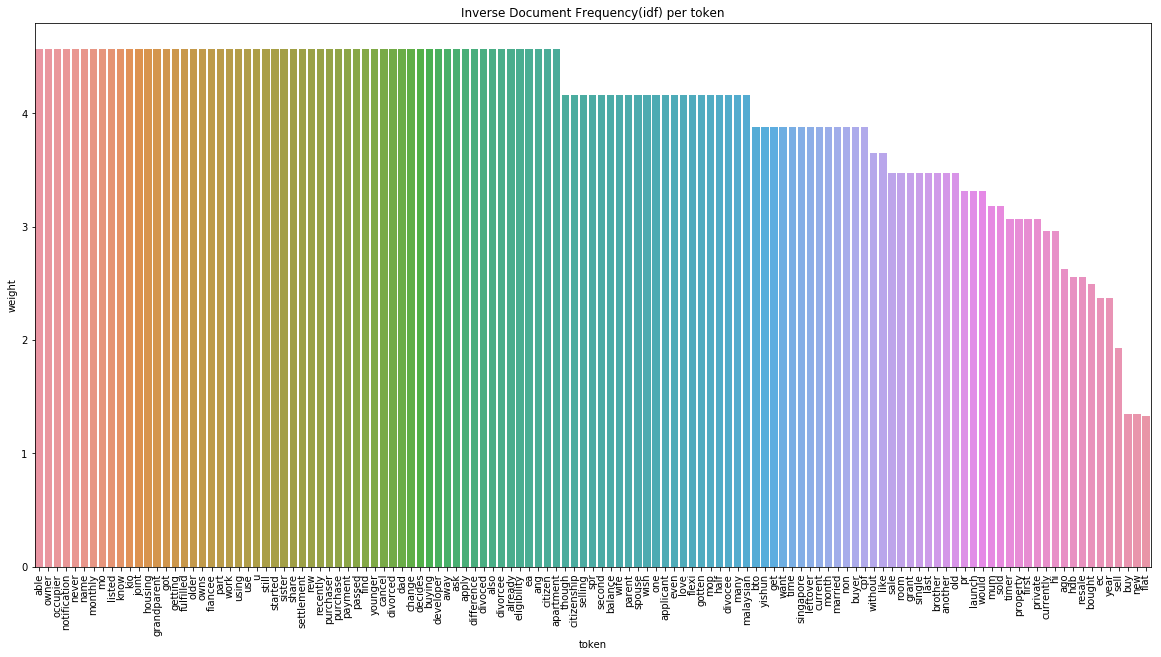

In [7]:
import seaborn as sns

idf = tfidf.idf_

data = dict(zip(vocab, idf))

token_weight = pd.DataFrame.from_dict(data, orient='index').reset_index()
token_weight.columns=('token','weight')
token_weight = token_weight.sort_values(by='weight', ascending=False)
token_weight 

sns.barplot(x='token', y='weight', data=token_weight)            
plt.title("Inverse Document Frequency(idf) per token")

plt.xticks(rotation=90)
fig=plt.gcf()
fig.set_size_inches(20,10)
plt.show()

## PCA 

[Text(0, 0.5, 'cumulative explained variance'),
 Text(0.5, 0, 'k'),
 Text(0.5, 1.0, 'PCA explained variance')]

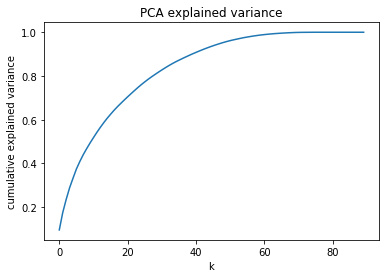

In [47]:
from sklearn.decomposition import PCA
pca = PCA(n_components=90)

X_pca = tfidf.fit_transform(df['questions'].values).todense()
pca.fit(X_pca)


fig, ax = plt.subplots()
ax.plot(pca.explained_variance_ratio_.cumsum())
ax.set(title='PCA explained variance', xlabel='k',
       ylabel='cumulative explained variance')


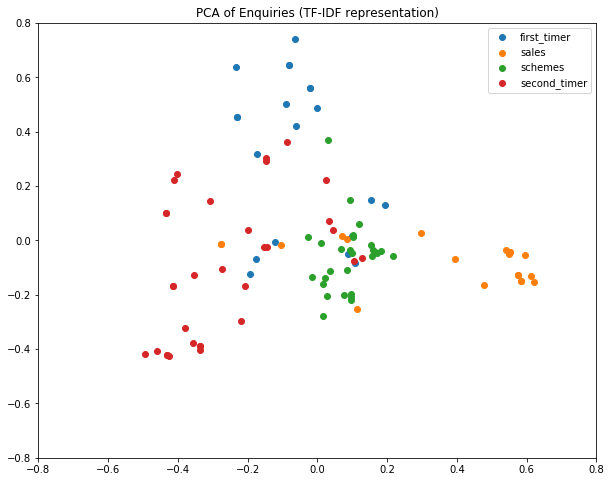

In [11]:
pca = PCA(n_components=2)
X_pca_2d = pca.fit_transform(X_tf.todense())

fig, ax = plt.subplots(figsize=(10, 8))


ax.scatter(X_pca_2d[y_le==0, 0], X_pca_2d[y_le==0, 1], label='first_timer')
ax.scatter(X_pca_2d[y_le==1, 0], X_pca_2d[y_le==1, 1], label='sales')
ax.scatter(X_pca_2d[y_le==2, 0], X_pca_2d[y_le==2, 1], label='schemes')
ax.scatter(X_pca_2d[y_le==3, 0], X_pca_2d[y_le==3, 1], label='second_timer')


ax.set_ylim(-0.8, 0.8)
ax.set_xlim(-0.8, 0.8)

ax.set(title='PCA of Enquiries (TF-IDF representation)')

ax.legend()

## Count Vectorizer

In [48]:
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

class LemmaTokenizer(object):
    def __init__(self):
        self.lemma = WordNetLemmatizer()
        self.stop = set(stopwords.words('english'))

    def __call__(self, doc):

       # tokenize text into tokens
       tokens = word_tokenize(doc)

       # strip out punctuation
       words = [t for t in tokens if t.isalpha()]

       # strip out stopwords
       words = [t for t in words if t not in self.stop]

       # lemmatize each token
       return [self.lemma.lemmatize(t) for t in words]

cvt = CountVectorizer(analyzer='word', tokenizer=LemmaTokenizer())

X_train_cvt = cvt.fit_transform(X_train.values)
X_test_cvt = cvt.transform(X_test.values)

vocab = cvt.get_feature_names() 

print(X_train_cvt.shape)
print(X_test_cvt.shape)
print('vocabulary size:',len(vocab))
print(vocab)

(70, 123)
(30, 123)
vocabulary size: 123
['able', 'ago', 'already', 'also', 'ang', 'another', 'apartment', 'applicant', 'apply', 'ask', 'away', 'balance', 'bought', 'brother', 'bto', 'buy', 'buyer', 'buying', 'cancel', 'change', 'citizen', 'citizenship', 'cpf', 'current', 'currently', 'dad', 'decides', 'developer', 'difference', 'divoced', 'divocee', 'divorced', 'divorcee', 'ea', 'ec', 'eligibility', 'even', 'fiancee', 'find', 'first', 'flat', 'flexi', 'fulfilled', 'get', 'getting', 'got', 'gotten', 'grandparent', 'grant', 'half', 'hdb', 'hi', 'housing', 'joint', 'kio', 'know', 'last', 'launch', 'leftover', 'like', 'listed', 'love', 'malaysian', 'many', 'married', 'mo', 'month', 'monthly', 'mop', 'mum', 'name', 'never', 'new', 'non', 'notification', 'occupier', 'old', 'older', 'one', 'owner', 'owns', 'parent', 'part', 'passed', 'payment', 'pr', 'private', 'property', 'purchase', 'purchaser', 'recently', 'resale', 'rew', 'room', 'sale', 'second', 'sell', 'selling', 'settlement', 'share'

### Clean text, tokenise,  lemmatize for
## Doc2vec

In [18]:
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer

from gensim import models
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# tokenize + lemmize

wnl = WordNetLemmatizer()

def LemmaTokenizer(text):
    tokens = word_tokenize(text)
    result = []
    for token in tokens:
        result.append(wnl.lemmatize(token))
    return result


 
X_train_tagged = df_train.apply(lambda row: TaggedDocument(words=LemmaTokenizer(row['questions']),
                                                          tags=[row.label]), axis=1)

X_test_tagged = df_test.apply(lambda row: TaggedDocument(words=LemmaTokenizer(row['questions']), 
                                                           tags=[row.label]), axis=1)

# X_train_tagged[0]

C:\Users\surface\Anaconda2\envs\mldds\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# Logistic Regression using SGD based on TFIDF

### Train the model

In [8]:
# train the logistic regression classifier

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, cross_validate, learning_curve
from sklearn.metrics import classification_report, confusion_matrix

model_sgd_tf = SGDClassifier(max_iter=1000, tol=1e-3)

scores_sgd_tf = cross_validate(model_sgd_tf, X_train_tf, y_train_le, cv=5,
                        return_train_score = True, return_estimator=True)


scores_sgd_tf

{'fit_time': array([0.01398683, 0.00199842, 0.00199628, 0.00399446, 0.0019989 ]),
 'score_time': array([0.        , 0.        , 0.00100088, 0.        , 0.        ]),
 'estimator': (SGDClassifier(alpha=0.0001, average=False, class_weight=None,
         early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
         l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=1000,
         n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
         power_t=0.5, random_state=None, shuffle=True, tol=0.001,
         validation_fraction=0.1, verbose=0, warm_start=False),
  SGDClassifier(alpha=0.0001, average=False, class_weight=None,
         early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
         l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=1000,
         n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
         power_t=0.5, random_state=None, shuffle=True, tol=0.001,
         validation_fraction=0.1, verbose=0, warm_start

### Unable to do learning curve because of small data set

ValueError: The number of classes has to be greater than one; got 1 class


#### In the absence of learning curve, we choose the best model best on the highest test score from the model training 

In [9]:
best_model_sgd_tf = scores_sgd_tf['estimator'][2]

best_test_score_sgd_tf = scores_sgd_tf['test_score'][2]
best_test_score_sgd_tf

0.9285714285714286

### Metrics 

In [12]:
y_pred_sgd_tf = best_model_sgd_tf.predict(X_test_tf)

print(classification_report(y_test_le, y_pred_sgd_tf, 
                            target_names= le.inverse_transform([0,1,2,3])
                           )
     )

print(confusion_matrix(y_test_le, y_pred_sgd_tf))


                        precision    recall  f1-score   support

 first_timer_applicant       0.67      0.80      0.73         5
                 sales       0.90      0.90      0.90        10
                scheme       1.00      0.70      0.82        10
second_timer_applicant       0.71      1.00      0.83         5

             micro avg       0.83      0.83      0.83        30
             macro avg       0.82      0.85      0.82        30
          weighted avg       0.86      0.83      0.83        30

[[4 0 0 1]
 [0 9 0 1]
 [2 1 7 0]
 [0 0 0 5]]


## Logistic Regression using SGD based on Count Vector

In [22]:
# train the logistic regression classifier

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, cross_validate, learning_curve
from sklearn.metrics import classification_report, confusion_matrix

model_sgd_cv = SGDClassifier(max_iter=1000, tol=1e-3)

scores_sgd_cv = cross_validate(model_sgd_cv, X_train_cvt, y_train_le, cv=5,
                        return_train_score = True, return_estimator=True)


scores_sgd_cv

{'fit_time': array([0.00399375, 0.00399995, 0.00399828, 0.00399995, 0.00399852]),
 'score_time': array([0.        , 0.        , 0.        , 0.        , 0.00399828]),
 'estimator': (SGDClassifier(alpha=0.0001, average=False, class_weight=None,
         early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
         l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=1000,
         n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
         power_t=0.5, random_state=None, shuffle=True, tol=0.001,
         validation_fraction=0.1, verbose=0, warm_start=False),
  SGDClassifier(alpha=0.0001, average=False, class_weight=None,
         early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
         l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=1000,
         n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
         power_t=0.5, random_state=None, shuffle=True, tol=0.001,
         validation_fraction=0.1, verbose=0, warm_start

In [23]:
best_model_sgd_cv = scores_sgd_cv['estimator'][2]

best_test_score_sgd_cv = scores_sgd_cv['test_score'][2]
best_test_score_sgd_cv

0.9285714285714286

### Metrics

In [24]:
y_pred_sgd_cv = best_model_sgd_cv.predict(X_test_cvt)

print(classification_report(y_test_le, y_pred_sgd_cv, 
                            target_names= le.inverse_transform([0,1,2,3])
                           )
     )


print(confusion_matrix(y_test_le, y_pred_sgd_cv))

                        precision    recall  f1-score   support

 first_timer_applicant       0.80      0.80      0.80         5
                 sales       0.89      0.80      0.84        10
                scheme       1.00      0.70      0.82        10
second_timer_applicant       0.56      1.00      0.71         5

             micro avg       0.80      0.80      0.80        30
             macro avg       0.81      0.82      0.79        30
          weighted avg       0.86      0.80      0.81        30

[[4 0 0 1]
 [0 8 0 2]
 [1 1 7 1]
 [0 0 0 5]]


## Logistic Regression using SGD based on Doc2vec

### Building the vocabulary

In [19]:
# Building the vocabulary

vector_size = 8

model_d2v = Doc2Vec(dm=0, vector_size = vector_size, hs=0, min_count=2, sample = 0)

vocab_list = model_d2v.build_vocab(X_train_tagged.values)

# number of document tags
len(model_d2v.docvecs) 

4

In [20]:
vocab_size = len(model_d2v.wv.vocab)
vocab_size

136

### Train the model

In [21]:
# Train the model

model_d2v.train(X_train_tagged.values, total_examples = len(X_train_tagged.values), epochs= 70)

## Build the vectors for the classifier

In [26]:
# Build the vectors for the classifier

def vec_for_learning(doc2vec_model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], doc2vec_model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

y_train_vectors, X_train_vectors = vec_for_learning(model_d2v, X_train_tagged)
y_test_vectors, X_test_vectors = vec_for_learning(model_d2v, X_test_tagged)

In [27]:
# train the logistic regression classifier

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, cross_validate, learning_curve
from sklearn.metrics import classification_report, confusion_matrix

model_sgd_d2v = SGDClassifier(max_iter=1000, tol=1e-3)

scores_sgd_d2v = cross_validate(model_sgd_d2v, X_train_vectors, y_train_vectors, cv=5, 
                        return_train_score = True, return_estimator=True)


scores_sgd_d2v

{'fit_time': array([0.00199628, 0.00199938, 0.00199962, 0.0029974 , 0.00199962]),
 'score_time': array([0.        , 0.00099874, 0.00099969, 0.        , 0.        ]),
 'estimator': (SGDClassifier(alpha=0.0001, average=False, class_weight=None,
         early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
         l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=1000,
         n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
         power_t=0.5, random_state=None, shuffle=True, tol=0.001,
         validation_fraction=0.1, verbose=0, warm_start=False),
  SGDClassifier(alpha=0.0001, average=False, class_weight=None,
         early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
         l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=1000,
         n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
         power_t=0.5, random_state=None, shuffle=True, tol=0.001,
         validation_fraction=0.1, verbose=0, warm_start

#### In the absence of learning curve, we choose the best model best on the highest test score from the model training 

In [28]:
best_model_sgd_d2v = scores_sgd_d2v['estimator'][4]

best_test_score_sgd_2dv = scores_sgd_d2v['test_score'][4]
best_test_score_sgd_2dv

0.8461538461538461

### Metrics

In [29]:
y_pred_d2v = best_model_sgd_d2v.predict(X_test_vectors)

print(classification_report(y_test, y_pred_d2v))

print(confusion_matrix(y_test, y_pred_d2v))

                        precision    recall  f1-score   support

 first_timer_applicant       0.71      1.00      0.83         5
                 sales       1.00      0.90      0.95        10
                scheme       1.00      0.70      0.82        10
second_timer_applicant       0.71      1.00      0.83         5

             micro avg       0.87      0.87      0.87        30
             macro avg       0.86      0.90      0.86        30
          weighted avg       0.90      0.87      0.87        30

[[5 0 0 0]
 [0 9 0 1]
 [2 0 7 1]
 [0 0 0 5]]


# MLP based on TFIDF

### Train the model

In [28]:
n_samples = 1
# n_features = 10   # max features
n_components = 1   # number of topics to be discovered
n_top_words = 5


def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [29]:
# trying to build a simple sequential Neural Network model 
# hidden layer : 16 nodes
# use categorical cross entropy as the cost function.

from keras.models import Sequential
from keras.layers import Dense

num_classes = 4


vocab_size = len(vocab)

 
 
print('vocabulary size:', vocab_size)    
    
model = Sequential()

model.add(Dense(128, activation='relu', input_shape=(vocab_size,)))
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

vocabulary size: 123
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               15872     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 516       
Total params: 32,900
Trainable params: 32,900
Non-trainable params: 0
_________________________________________________________________


In [30]:
print(X_test_tf.shape)
print(y_test_oh.shape)

(30, 123)
(30, 4)


In [31]:
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD
import time

epochs = 350                        
batch_size = 10


model.compile(loss='categorical_crossentropy',
              optimizer=SGD(),
              metrics=['accuracy']) # Tensorboard will display
                                    # acc in addition to loss
    
#callback
tb = TensorBoard(log_dir='./logs/{}'.format(int(time.time())))
mc = ModelCheckpoint('./logs/project_tfidf.{epoch:02d}-{val_loss:.2f}.hdf5')
# es = EarlyStopping(patience=1)


history = model.fit(X_train_tf, y_train_oh,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks=[tb,mc],
                    validation_data=(X_test_tf, y_test_oh))

Train on 70 samples, validate on 30 samples
Epoch 1/350
70/70 [==============================] - 0s 2ms/step - loss: 1.3733 - acc: 0.3286 - val_loss: 1.3837 - val_acc: 0.3333
Epoch 2/350
70/70 [==============================] - 0s 226us/step - loss: 1.3668 - acc: 0.4000 - val_loss: 1.3846 - val_acc: 0.1667
Epoch 3/350
70/70 [==============================] - 0s 229us/step - loss: 1.3610 - acc: 0.4286 - val_loss: 1.3857 - val_acc: 0.2000
Epoch 4/350
70/70 [==============================] - 0s 400us/step - loss: 1.3548 - acc: 0.3857 - val_loss: 1.3867 - val_acc: 0.1667
Epoch 5/350
70/70 [==============================] - 0s 286us/step - loss: 1.3490 - acc: 0.4000 - val_loss: 1.3879 - val_acc: 0.1667
Epoch 6/350
70/70 [==============================] - 0s 286us/step - loss: 1.3440 - acc: 0.4000 - val_loss: 1.3891 - val_acc: 0.1667
Epoch 7/350
70/70 [==============================] - 0s 343us/step - loss: 1.3380 - acc: 0.3857 - val_loss: 1.3904 - val_acc: 0.1667
Epoch 8/350
70/70 [========

Epoch 62/350
70/70 [==============================] - 0s 286us/step - loss: 1.1433 - acc: 0.3857 - val_loss: 1.3310 - val_acc: 0.1667
Epoch 63/350
70/70 [==============================] - 0s 286us/step - loss: 1.1393 - acc: 0.3857 - val_loss: 1.3277 - val_acc: 0.1667
Epoch 64/350
70/70 [==============================] - 0s 343us/step - loss: 1.1350 - acc: 0.4000 - val_loss: 1.3239 - val_acc: 0.1667
Epoch 65/350
70/70 [==============================] - 0s 286us/step - loss: 1.1309 - acc: 0.4000 - val_loss: 1.3202 - val_acc: 0.1667
Epoch 66/350
70/70 [==============================] - 0s 286us/step - loss: 1.1266 - acc: 0.4000 - val_loss: 1.3164 - val_acc: 0.1667
Epoch 67/350
70/70 [==============================] - 0s 286us/step - loss: 1.1229 - acc: 0.4000 - val_loss: 1.3122 - val_acc: 0.1667
Epoch 68/350
70/70 [==============================] - 0s 286us/step - loss: 1.1185 - acc: 0.4286 - val_loss: 1.3082 - val_acc: 0.1667
Epoch 69/350
70/70 [==============================] - 0s 286us

Epoch 123/350
70/70 [==============================] - 0s 286us/step - loss: 0.8002 - acc: 0.8000 - val_loss: 0.9776 - val_acc: 0.7000
Epoch 124/350
70/70 [==============================] - 0s 286us/step - loss: 0.7921 - acc: 0.8000 - val_loss: 0.9709 - val_acc: 0.7000
Epoch 125/350
70/70 [==============================] - 0s 286us/step - loss: 0.7854 - acc: 0.8000 - val_loss: 0.9636 - val_acc: 0.7000
Epoch 126/350
70/70 [==============================] - 0s 286us/step - loss: 0.7784 - acc: 0.8000 - val_loss: 0.9571 - val_acc: 0.7000
Epoch 127/350
70/70 [==============================] - 0s 228us/step - loss: 0.7719 - acc: 0.8000 - val_loss: 0.9495 - val_acc: 0.7000
Epoch 128/350
70/70 [==============================] - 0s 285us/step - loss: 0.7649 - acc: 0.8000 - val_loss: 0.9403 - val_acc: 0.7333
Epoch 129/350
70/70 [==============================] - 0s 228us/step - loss: 0.7579 - acc: 0.8143 - val_loss: 0.9342 - val_acc: 0.7333
Epoch 130/350
70/70 [==============================] - 

Epoch 184/350
70/70 [==============================] - 0s 286us/step - loss: 0.4220 - acc: 0.9429 - val_loss: 0.5753 - val_acc: 0.8667
Epoch 185/350
70/70 [==============================] - 0s 286us/step - loss: 0.4155 - acc: 0.9429 - val_loss: 0.5706 - val_acc: 0.8333
Epoch 186/350
70/70 [==============================] - 0s 285us/step - loss: 0.4108 - acc: 0.9429 - val_loss: 0.5686 - val_acc: 0.8333
Epoch 187/350
70/70 [==============================] - 0s 228us/step - loss: 0.4059 - acc: 0.9429 - val_loss: 0.5639 - val_acc: 0.8333
Epoch 188/350
70/70 [==============================] - 0s 400us/step - loss: 0.4009 - acc: 0.9429 - val_loss: 0.5600 - val_acc: 0.8333
Epoch 189/350
70/70 [==============================] - 0s 229us/step - loss: 0.3971 - acc: 0.9429 - val_loss: 0.5551 - val_acc: 0.8333
Epoch 190/350
70/70 [==============================] - 0s 286us/step - loss: 0.3923 - acc: 0.9571 - val_loss: 0.5504 - val_acc: 0.8333
Epoch 191/350
70/70 [==============================] - 

Epoch 245/350
70/70 [==============================] - 0s 342us/step - loss: 0.2145 - acc: 0.9857 - val_loss: 0.4001 - val_acc: 0.8333
Epoch 246/350
70/70 [==============================] - 0s 286us/step - loss: 0.2128 - acc: 0.9857 - val_loss: 0.3996 - val_acc: 0.8333
Epoch 247/350
70/70 [==============================] - 0s 286us/step - loss: 0.2098 - acc: 0.9857 - val_loss: 0.3980 - val_acc: 0.8333
Epoch 248/350
70/70 [==============================] - 0s 286us/step - loss: 0.2076 - acc: 0.9857 - val_loss: 0.3970 - val_acc: 0.8333
Epoch 249/350
70/70 [==============================] - 0s 228us/step - loss: 0.2054 - acc: 0.9857 - val_loss: 0.3961 - val_acc: 0.8333
Epoch 250/350
70/70 [==============================] - 0s 343us/step - loss: 0.2040 - acc: 0.9857 - val_loss: 0.3956 - val_acc: 0.8333
Epoch 251/350
70/70 [==============================] - 0s 286us/step - loss: 0.2010 - acc: 0.9857 - val_loss: 0.3928 - val_acc: 0.8333
Epoch 252/350
70/70 [==============================] - 

Epoch 306/350
70/70 [==============================] - 0s 343us/step - loss: 0.1203 - acc: 0.9857 - val_loss: 0.3498 - val_acc: 0.9000
Epoch 307/350
70/70 [==============================] - 0s 286us/step - loss: 0.1198 - acc: 0.9857 - val_loss: 0.3482 - val_acc: 0.9000
Epoch 308/350
70/70 [==============================] - 0s 286us/step - loss: 0.1192 - acc: 0.9857 - val_loss: 0.3476 - val_acc: 0.9000
Epoch 309/350
70/70 [==============================] - 0s 286us/step - loss: 0.1178 - acc: 0.9857 - val_loss: 0.3473 - val_acc: 0.9000
Epoch 310/350
70/70 [==============================] - 0s 286us/step - loss: 0.1165 - acc: 0.9857 - val_loss: 0.3471 - val_acc: 0.9000
Epoch 311/350
70/70 [==============================] - 0s 286us/step - loss: 0.1154 - acc: 0.9857 - val_loss: 0.3476 - val_acc: 0.9000
Epoch 312/350
70/70 [==============================] - 0s 229us/step - loss: 0.1144 - acc: 0.9857 - val_loss: 0.3470 - val_acc: 0.9000
Epoch 313/350
70/70 [==============================] - 

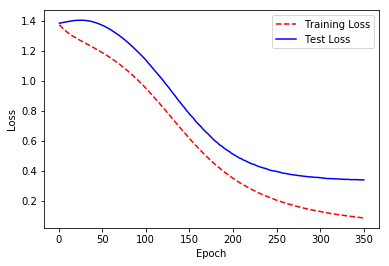

In [32]:
# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

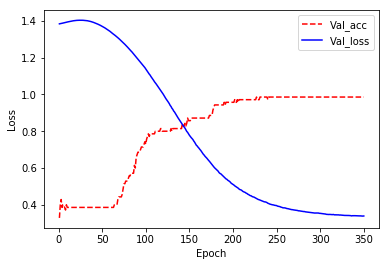

In [33]:
# Get training and test loss histories
training_loss = history.history['acc']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Val_acc', 'Val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

### Metrics

In [34]:
y_pred = model.predict_classes(X_test_tf) 

print(y_pred)  

[0 0 0 0 0 1 1 1 1 3 1 1 1 1 1 2 0 2 2 2 2 2 0 2 2 3 3 3 3 3]


In [35]:
print(classification_report(y_test_oh.argmax(axis=1), y_pred))

print(confusion_matrix(y_test_oh.argmax(axis=1), y_pred, ))

              precision    recall  f1-score   support

           0       0.71      1.00      0.83         5
           1       1.00      0.90      0.95        10
           2       1.00      0.80      0.89        10
           3       0.83      1.00      0.91         5

   micro avg       0.90      0.90      0.90        30
   macro avg       0.89      0.93      0.89        30
weighted avg       0.92      0.90      0.90        30

[[5 0 0 0]
 [0 9 0 1]
 [2 0 8 0]
 [0 0 0 5]]


In [10]:
dfr = pd.read_csv('response.csv')
dfr1 = pd.DataFrame(dfr)
dfr1.set_index('label', inplace=True)

In [14]:
test = ['when is a good time to sell ?']

# test = [input()]


test_tf = tfidf.transform(np.array(test))
y_pred_test = best_model_sgd_tf.predict(test_tf)
answer = le.inverse_transform(y_pred_test)

dfr1.loc[answer[0], 'response']

'Every Singaporean can buy new HDB or EC twice , provided they pay back the first subsidy in the form of resale levy and fulfilling the  Mininium Occupation Period.'